In [112]:
#######################################################################
#
# Name: Hussein Nagree
# Course: Introduction to Connectomics, Spring 2016
# Description: This ipython notebook reads in from an ImageJ dataset
#              consisting of timeseries of mouse brain neuron activity.
#              It also reads in a labeling of neurons in these images,
#              and learns the neuron labeling to automate that process
#              in any similar sized brain scan.
#
#######################################################################

In [113]:
#######################################################################
#
# Code to read in tif files and neuron labelings, given the filenames.
#
# load_stacks takes in the tif file, and returns a 3D numpy array of 
# time*xdimension*ydimension
#
# load_rois takes in a zip file containing rois, width and height
# (usually 512*512 for the images given), as well as optional args
# for fill, x displacement, and y displacement (by default 1, 0, 0).
# It returns a numpy array of 0-1 matrices, where each matrix holds 1
# roi. An roi is visible as a roughly sphere-shaped area, usually 
# between 100 - 350 pixels, of 1s. The rest of each 512*512 matrix
# is 0s
#
#######################################################################


from PIL import Image, ImageDraw
import numpy as np

# https://gist.github.com/luispedro/3437255
# Copyright: Luis Pedro Coelho <luis@luispedro.org>, 2012
# License: MIT

def read_roi(fileobj):
# This is based on:
# http://rsbweb.nih.gov/ij/developer/source/ij/io/RoiDecoder.java.html
# http://rsbweb.nih.gov/ij/developer/source/ij/io/RoiEncoder.java.html


    SPLINE_FIT = 1
    DOUBLE_HEADED = 2
    OUTLINE = 4
    OVERLAY_LABELS = 8
    OVERLAY_NAMES = 16
    OVERLAY_BACKGROUNDS = 32
    OVERLAY_BOLD = 64
    SUB_PIXEL_RESOLUTION = 128
    DRAW_OFFSET = 256


    pos = [4]
    def get8():
        pos[0] += 1
        s = fileobj.read(1)
        if not s:
            raise IOError('readroi: Unexpected EOF')
        return ord(s)

    def get16():
        b0 = get8()
        b1 = get8()
        return (b0 << 8) | b1

    def get32():
        s0 = get16()
        s1 = get16()
        return (s0 << 16) | s1

    def getfloat():
        v = np.int32(get32())
        return v.view(np.float32)

    magic = fileobj.read(4)
    if magic != b'Iout':
        raise IOError('Magic number not found. Value = ' + str(magic))
    version = get16()

    # It seems that the roi type field occupies 2 Bytes, but only one is used
    roi_type = get8()
    # Discard second Byte:
    get8()

    if not (0 <= roi_type < 11):
        raise ValueError('roireader: ROI type %s not supported' % roi_type)

    if roi_type != 7:
        raise ValueError('roireader: ROI type %s not supported (!= 7)' % roi_type)

    top = get16()
    left = get16()
    bottom = get16()
    right = get16()
    n_coordinates = get16()

    x1 = getfloat() 
    y1 = getfloat() 
    x2 = getfloat() 
    y2 = getfloat()
    stroke_width = get16()
    shape_roi_size = get32()
    stroke_color = get32()
    fill_color = get32()
    subtype = get16()
    if subtype != 0:
        raise ValueError('roireader: ROI subtype %s not supported (!= 0)' % subtype)
    options = get16()
    arrow_style = get8()
    arrow_head_size = get8()
    rect_arc_size = get16()
    position = get32()
    header2offset = get32()

    if options & SUB_PIXEL_RESOLUTION:
        getc = getfloat
        points = np.empty((n_coordinates, 2), dtype=np.float32)
    else:
        getc = get16
        points = np.empty((n_coordinates, 2), dtype=np.int16)
    points[:,1] = [getc() for i in range(n_coordinates)]
    points[:,0] = [getc() for i in range(n_coordinates)]
    points[:,1] += left
    points[:,0] += top
    points -= 1
    return points

def read_roi_zip(fname):
    import zipfile
    zf = zipfile.ZipFile(fname)
    x = []
    for n in zf.namelist():
        x.append(read_roi(zf.open(n)))
    zf.close()
    return x
    
# tif -> (time,w,h)
def load_stacks(path):
    im = Image.open(path)
    stk = []
    while True:
        stk.append(np.array(im))
        try:
            im.seek(len(stk))
        except EOFError:
            break
    return np.array(stk, dtype='float32')

# roi zip -> (index,w,h)
def load_roi(path, width, height, fill=1, xdisp=0, ydisp=0):
    rois = read_roi_zip(path)
    ret = []
    for i,roi in enumerate(rois):
        poly = []
        for x in roi:
            poly.append((x[1],x[0]))
        img = Image.new('L', (width, height), 0)
        ImageDraw.Draw(img).polygon(poly, outline=1, fill=fill)
        ret.append(np.array(img))
    return np.array(ret,dtype='float32')


In [114]:
#######################################################################
#
# Set up the variables that store all the data.
#
# files contains an array of tuples of (tif_file, zip_file). It assumes
# that all the files are stored in a directory called data, with each
# file named 'AMG[1-3]_exp[1-4].[tif/zip]', as mentioned in the dataset
# given to us by Jan
#
# data is an array of (stacks, rois) corresponding to (tif, zip) files.
# Each stack and roi is loaded using load_stacks and load_roi, and is
# a 3D array of size (num_frames/num_rois)*512*512
#
# Takes about 30s to run.
#
#######################################################################

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import laplace
from skimage import feature

plt.rcParams['figure.figsize'] = (16, 16)

# generate filenames
files = []
for i in range(1,4):
    for j in range(1,5):
        prefix = 'data/AMG%d_exp%d'%(i,j)
        files.append( (prefix+'.tif', prefix+'.zip') )
        
# load data
data = []
for i,(s,r) in enumerate(files):
    if i==8: # lolwtf
        data.append((load_stacks(s), load_roi(r, 512, 512, xdisp=9, ydisp=-1)))
    else:
        data.append((load_stacks(s), load_roi(r, 512, 512)))


In [ ]:
#######################################################################
#
# OPTIONAL: View some sample rois in tiles individually
#
#######################################################################

def NormalizeTile(tile):
    return (tile - tile.mean()) / tile.std()

w,h = [], []
tiles = []
Ztiles = []
r = 10

for stk, rois in data:
    M = stk.max(axis=0)
    for roi in rois:
        x,y = np.where(roi!=0)
        x,y = int(x.mean()), int(y.mean()) # compute centroid of roi
        if x-r>=0 and y-r>=0 and x+r<512 and y+r<512:
            tiles.append(M[x-r:x+r, y-r:y+r]) # grab tile
            Ztiles.append(NormalizeTile(M[x-r:x+r, y-r:y+r])) # grab z-scored tile
            
tiles = np.array(tiles)
Ztiles = np.array(Ztiles)

# render tiled image
Q = np.zeros((2*r*10, 2*r*10))
for i in range(10):
    for j in range(10):
        Q[2*r*i:2*r*(i+1),2*r*j:2*r*(j+1)] = Ztiles[10*i + j]

plt.imshow(Q,cmap='gray')


In [ ]:
#######################################################################
#
# OPTIONAL: View the training set. Each roi is overlaid in blue over
# the neurons. Each pixel is calculated as its (max - std dev) over
# time in the stack.
#
#######################################################################

# Pick one set
stk,rois = data[0]

# Show image of the data set
M = stk.max(axis=0) - stk.std(axis=0)
M = np.clip((M-900)/400, 0, 1)
M**=0.5

R = rois.max(axis=0) 

K = np.zeros((512,512,3))
K[:,:,0] = K[:,:,1] = K[:,:,2] = M
K[:,:,2] = np.maximum(M,R)

plt.imshow(K)


In [133]:
#######################################################################
#
# Preprocess the rois in the training set. Make sure that old_rois is
# picked from the correct set. Since the algorithm is a sliding window
# to decide if the pixel at the center of the window is in a neuron
# nucleus, the preprocessing shrinks each roi to try and exclude the
# cell bodies. By removing the boundary pixels in each roi, it
# effectively reduces the size of each roi by 20% - 25%.
#
# Takes about 2 mins.
#
#######################################################################

# Select the training dataset
stk,old_rois = data[0]

# Trim the rois, but don't actually change the original values in case
# they need to be reused.
rois = np.array(old_rois)

dimensions = 512
# for roi in rois:
#     # Mark the border pixels to be set to 0 
#     for i in range(0, dimensions):
#         for j in range(0, dimensions):
#             if roi[i,j] == 1:
#                 if i > 0 and roi[i-1,j] == 0:
#                     roi[i, j] = 2
#                 elif j > 0 and roi[i, j-1] == 0:
#                     roi[i, j] = 2
#                 elif i < dimensions - 1 and roi[i+1, j] == 0:
#                     roi[i, j] = 2
#                 elif j < dimensions - 1 and roi[i, j+1] == 0:
#                     roi[i, j] = 2

#     for i in range(0,dimensions):
#         for j in range(0,dimensions):
#             if roi[i,j] == 2:
#                 roi[i,j] = 0


In [134]:
#######################################################################
#
# Train an SVM. Use the preprocessed rois from the previous segment,
# and slightly process the input stacks. Convert the image into an
# array of feature vectors (formed from the sliding window around each
# pixel), and the rois into an array of 0-1 values corresponding to
# whether the pixel is in the nucleus of the neuron or not. Use the
# python SVC class. 
#
# Takes 7-8 minutes
#
#######################################################################

from sklearn.svm import SVC

# The radius of the sliding window
radius = 10

# The pixels skipped by the sliding window in each step
# (moving one pixel at a time is unnecessary since the window won't
# change much)
skip = 3

# The number of pixels to skip at the image boundaries 
# (since the edges tend to be mostly black)
edge = 100

# Slight preprocessing of the image. Each pixel is maximised over time,
# in order to increase brightness. Then, each pixel's std dev is subtracted,
# to increase contrast between nucleuses and cell bodies (which tend to have
# different variations in brightness over time). This is then adjusted to a
# (0, 1) range.
M = stk.max(axis=0) - stk.std(axis=0)
M = np.clip((M-900)/400, 0, 1 )
M**=0.5

# Overlay all the rois into a single matrix
R = rois.max(axis=0) 

# Take in a 2D square matrix of the 2*radius pixels around a pixel,
# and return a 1D array of features that have been extracted out of it.
def ExtractFeatures(tile):
    mid = tile[radius, radius]
    tile -= mid
    if tile.mean() != 0:
        tile = tile/tile.mean()
    return tile.flatten()

# Grab the appropriate parts of the training and label data
Y = R[edge:dimensions-edge:skip, edge:dimensions-edge:skip].flatten()

X = []
for i in range(edge, dimensions-edge, skip):
    for j in range(edge, dimensions-edge, skip):
        tile = np.array(M[i-radius:i+radius, j-radius:j+radius])
        X.append(ExtractFeatures(tile))

# Train the SVM using an rbf kernel
clf = SVC()
clf.fit(X,Y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
#######################################################################
#
# OPTIONAL: Validate on another dataset. Not too useful though, since
# the large number of true negatives (non-neuron spots) make the
# accuracy appear relatively large, even if the actual labeling of
# neurons is not that accurate.
#
#######################################################################

# Select the validation dataset
(stk, rois) = data[1]

M = stk.max(axis=0) - stk.std(axis=0)
M = np.clip((M-900)/400, 0, 1 )
M**=0.5

R = rois.max(axis=0) 

YValidate = R[radius:dimensions-radius, radius:dimensions-radius].flatten()

XValidate = []
for i in range(radius, dimensions-radius):
    for j in range(radius, dimensions-radius):
        tile = np.array(M[i-radius:i+radius, j-radius:j+radius])
        XValidate.append(ExtractFeatures(tile))
        
print(clf.score(XValidate, YValidate))


In [135]:
#######################################################################
#
# Test the SVM. Print the classification accuracy, as well as the total
# recall and precision of predicting positive results (pixels that are
# in a neuron). NOTE: This is not the final precisions and accuracy, as
# the agglomeration of pixels into rois will affect these values.
#
# Takes about 30 minutes. :-(
#
#######################################################################

# Select the test dataset
(stk, rois) = data[4]

M = stk.max(axis=0) - stk.std(axis=0)
M = np.clip((M-900)/400, 0, 1 )
M**=0.5

R = rois.max(axis=0) 

YReal = R[radius:dimensions-radius, radius:dimensions-radius].flatten()

XTest = []
for i in range(radius, dimensions-radius):
    for j in range(radius, dimensions-radius):
        tile = np.array(M[i-radius:i+radius, j-radius:j+radius])
        XTest.append(ExtractFeatures(tile))
        
YTest = clf.predict(XTest)

truepos = 0
falseneg = 0
falsepos = 0
count = 0
total = (dimensions-2*radius)**2

# Compare YReal (the actual labels) to YTest (our predicted labels)
for i in range(total):
    if YReal[i] == YTest[i]:
        count += 1
        if YTest[i] == 1:
            truepos += 1
    else:
        if YTest[i] == 1:
            falsepos += 1
        else:
            falseneg += 1

print("Recall: " + str(truepos/(truepos + falseneg)))
print("Precision: " + str(truepos/(truepos + falsepos)))
print("Accuracy: " + str(count/total))


Recall: 0.14977550704443413
Precision: 0.49427753934191704
Accuracy: 0.8661221825632891


In [138]:
#######################################################################
#
# Convert the 1D pixel predictions into 2D, and then agglomerate and
# separate high density neuron regions into individual rois, stored
# in the array out_rois. This is in the same format as the input rois
# when read in by load_roi.
#
#######################################################################

# Convert YTest back into a 2D matrix
out_pixels = np.zeros((dimensions, dimensions))
out_pixels[radius:dimensions-radius, radius:dimensions-radius] = np.reshape(YTest, (-1, dimensions-2*radius))
out_pixels_cpy = np.array(out_pixels)

# Array of rois to return
out_rois = []

# Returns probability that a box of size 2*r in out_pixels centered on (i, j) contains a neuron
def NeuronProb(i, j, r):
    return np.sum(out_pixels[i-r:i+r, j-r:j+r])/((2*r)**2)

# Adds an roi centered around i,j to out_rois, and removes it from out_pixels
def AddRoi(i, j):
    # Minimum, maximum radius of the potential roi
    r = 8
    # Add new roi
    patch = np.zeros((dimensions, dimensions))
    patch[i-r:i+r, j-r:j+r] = 1
    # Make it a sphere
    for x in range(0, 2*r):
        for y in range(0, 2*r):
            if (r-x)**2 + (r-y)**2 > r*r:
                patch[i-r+x, j-r+y] = 0
    out_rois.append(patch)
    # Remove 1s from that region
    out_pixels[np.where(patch == 1)] = 0

# Make radius more conservative when grouping neurons.
# The average neuron is about 150-200 pixels, so a circular neuron of
# radius 7 should encompass most of a typical neuron. 
rad = 7

# Threshold can be used to adjust the precision vs accuracy. Higher threshold
# leads to high precision but lower accuracy. 
threshold = 0.1

# Extract rois
for i in range(rad, dimensions-rad-1):
    for j in range(rad, dimensions-rad-1):
        prob = NeuronProb(i, j, rad)
        # Check right and bottom for continuation of same neuron
        if prob > threshold and prob > NeuronProb(i, j+1, rad) and prob > NeuronProb(i+1, j, rad):
            AddRoi(i,j)
            

Predicted number of rois: 172
Actual number of rois: 157


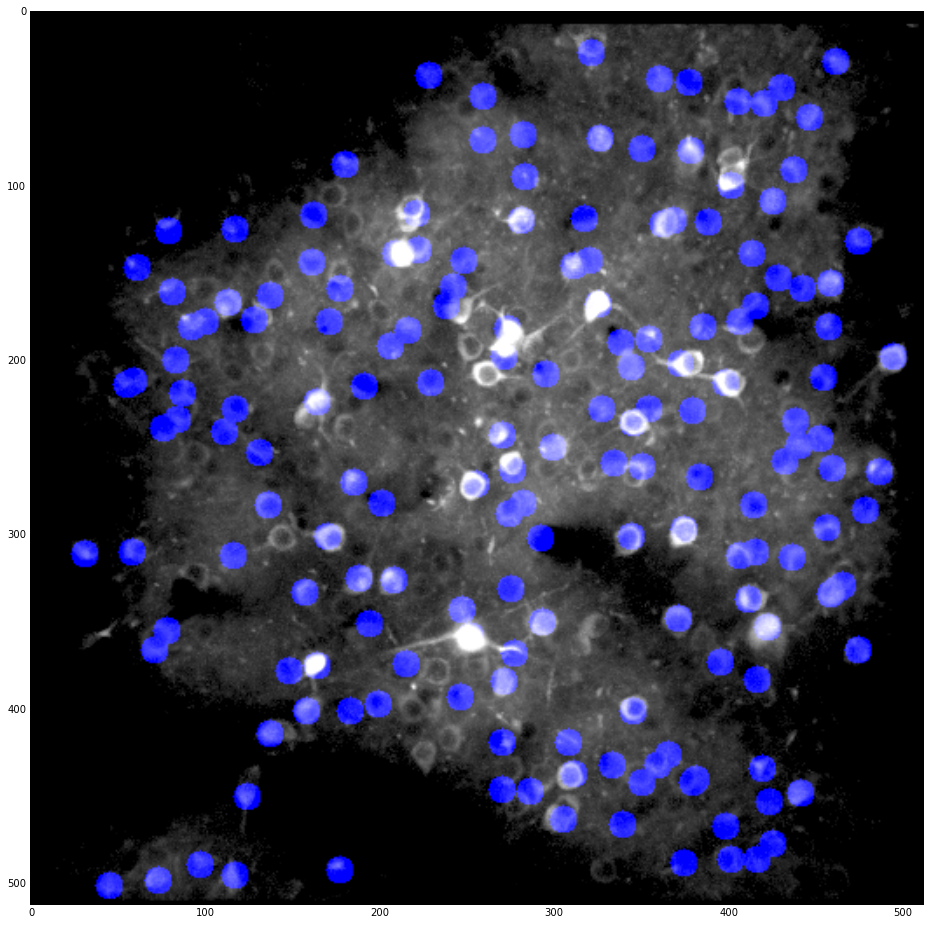

In [139]:
#######################################################################
#
# OPTIONAL: Compare the number of predicted and actual rois. Print
# the agglomerated rois overlayed over the test region to objectively
# observe the results of the SVM and grouping algorithms.
#
#######################################################################

print("Predicted number of rois: " + str(len(out_rois)))
print("Actual number of rois: " + str(rois.shape[0]))
K[:,:,0] = K[:,:,1] = M
# K[:,:,2] = np.maximum(M, out_pixels_cpy)
# plt.imshow(K)

K[:,:,2] = np.maximum(M, np.array(out_rois).max(axis=0))
plt.imshow(K)

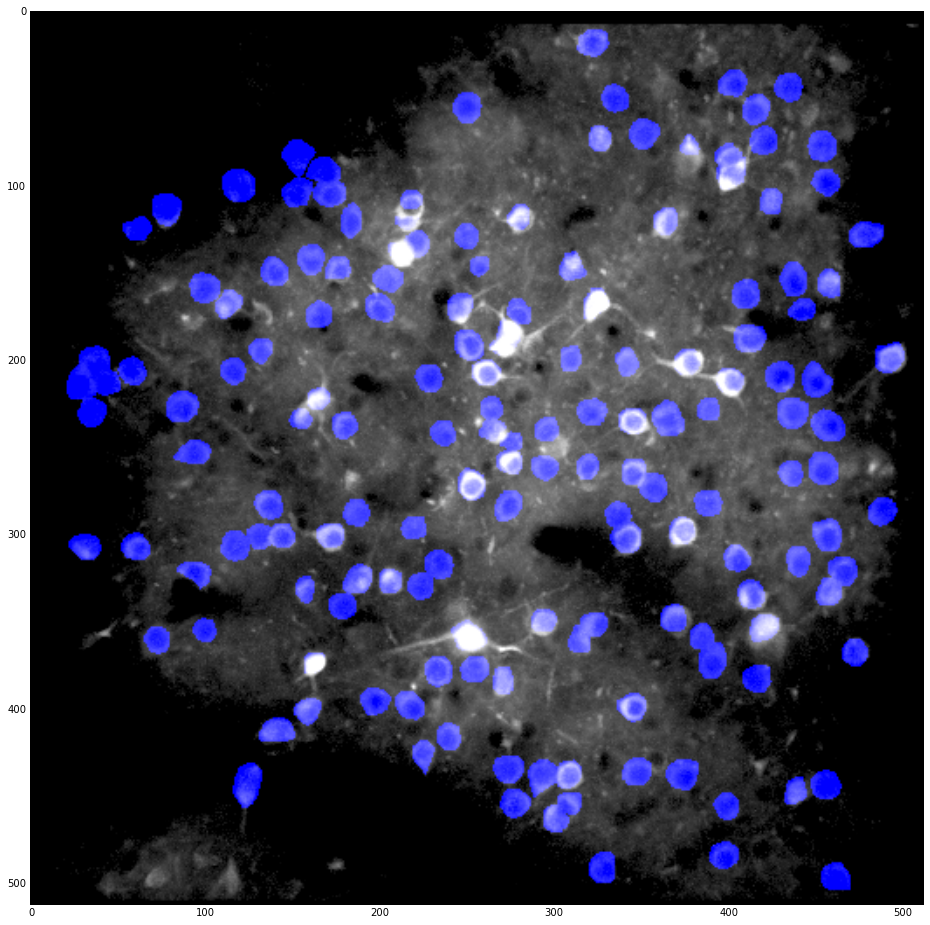

In [36]:

K[:,:,0] = K[:,:,1] = K[:,:,2] = M
K[:,:,2] = np.maximum(M,R)
plt.imshow(K)